In [1]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,decode_predictions,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping, Callback

In [2]:
import my_utils
import numpy as np
from my_utils.my_utils import create_generator, LossHistory
from IPython.display import clear_output
import importlib
importlib.reload(my_utils)
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
base_model = MobileNetV2(input_shape=(224,224,3),weights='imagenet', include_top=False)

In [4]:
NUMBER_OF_PHOTOS = 30000
input_shape = (224,224,3)
batch_size = 50
train_size = 0.9
validation_size = 0.05
test_size = 0.05

In [5]:
train_generator = create_generator(start = 0,stop=train_size,batch_size=batch_size)
validation_generator = create_generator(start = train_size,stop=train_size+validation_size,batch_size=batch_size)
test_generator = create_generator(start = train_size+validation_size,stop=min(1,train_size+validation_size+test_size),batch_size=batch_size)

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
opt=Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [8]:
model_name = "mob2gen09drop_deeper2"
history = Callback()
checkpoint = ModelCheckpoint(filepath="../models/{}.h5".format(model_name))
stopping = EarlyStopping(patience=9,restore_best_weights = True)

In [9]:
hist = model.fit_generator(generator=train_generator,
                              steps_per_epoch=int(NUMBER_OF_PHOTOS*train_size/batch_size),
                             validation_data=validation_generator,
                             validation_steps=int(NUMBER_OF_PHOTOS*validation_size/batch_size), epochs = 10,callbacks=[history,checkpoint,stopping])

Epoch 1/10
540/540 [==============================] - 2146s 4s/step - loss: 39.0306 - val_loss: 48.4679
Epoch 2/10
540/540 [==============================] - 2131s 4s/step - loss: 27.4404 - val_loss: 26.5020
Epoch 3/10
540/540 [==============================] - 2127s 4s/step - loss: 23.7892 - val_loss: 22.4197
Epoch 4/10
540/540 [==============================] - 2127s 4s/step - loss: 23.5739 - val_loss: 22.1720
Epoch 5/10
540/540 [==============================] - 2127s 4s/step - loss: 23.4374 - val_loss: 21.9962
Epoch 6/10
540/540 [==============================] - 2129s 4s/step - loss: 23.3130 - val_loss: 22.2766
Epoch 7/10
540/540 [==============================] - 2126s 4s/step - loss: 23.1021 - val_loss: 21.8902
Epoch 8/10
540/540 [==============================] - 2131s 4s/step - loss: 23.0631 - val_loss: 21.8395
Epoch 9/10
540/540 [==============================] - 2129s 4s/step - loss: 23.0351 - val_loss: 21.8723
Epoch 10/10
540/540 [==============================] - 2122s 4s/

In [10]:
test_generator = create_generator(start = train_size+validation_size,stop=min(1,train_size+validation_size+test_size),batch_size=batch_size)
model.evaluate_generator(test_generator,steps = int(NUMBER_OF_PHOTOS*test_size/batch_size))

23.80438009897868

In [11]:
test_generator = create_generator(start = train_size+validation_size,stop=min(1,train_size+validation_size+test_size),batch_size=batch_size)
Y_pred = model.predict_generator(test_generator,steps = int(NUMBER_OF_PHOTOS*test_size/batch_size))

Text(0.5, 1.0, 'Loss Curves for model mob2gen09drop_deeper2')

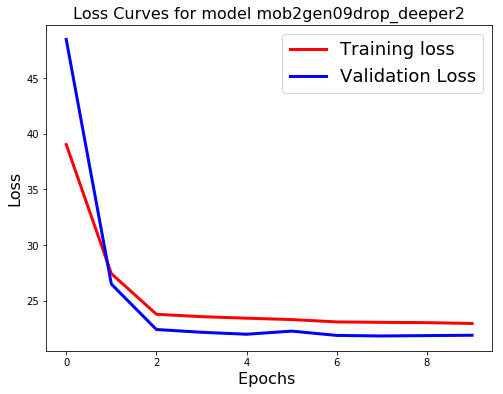

In [20]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'][0:],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'][0:],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves for model {}'.format(model_name),fontsize=16)
#plt.savefig("../pictures/{}.jpg".format(model_name))

In [17]:
# import json
# with open("../models/{}.json".format(model_name),"w") as f:
#     json.dump(history.history,f)